In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import VGG19

from tensorflow.keras.callbacks import EarlyStopping
# For reproducibility
np.random.seed(42)
from scipy import sparse


In [3]:
!ls

drive  sample_data


In [5]:
MAX_IMAGE = 300

In [6]:
target_path = '/content/drive/MyDrive/General Assembly/breast_cancer_project/breast_imaging_500px/cancer'

list_of_dirs = [x for x in os.listdir(target_path)]

image_count = 0
sparse_dir_cancer_list = []
for dir_name in list_of_dirs:
  path = f'{target_path}/{dir_name}'
  for dirs in os.listdir(path):
    image_count += 1
    sparse_dir_cancer_list.append(f'{path}/{dirs}')
    if image_count >= MAX_IMAGE:
      break
  if image_count >= MAX_IMAGE:
    break

In [7]:
target_path = '/content/drive/MyDrive/General Assembly/breast_cancer_project/breast_imaging_500px/no_cancer'

list_of_dirs = [x for x in os.listdir(target_path)]

image_count = 0
sparse_dir_no_cancer_list = []
for dir_name in list_of_dirs:
  path = f'{target_path}/{dir_name}'
  for dirs in os.listdir(path):
    image_count += 1
    sparse_dir_no_cancer_list.append(f'{path}/{dirs}')
    if image_count >= MAX_IMAGE:
      break

  if image_count >= MAX_IMAGE:
    break

In [15]:
from PIL import Image, ImageDraw
from tensorflow.keras.preprocessing.image import img_to_array, load_img, smart_resize

def apply_ct_window(img, window):
    # window = (window width, window level)
    R = (img-window[1]+0.5*window[0])/window[0]
    R[R<0] = 0
    R[R>1] = 1

    # print(R)
    return R

def convert_image_to_rgb(arr):

  display_img = apply_ct_window(arr, [400,50])

  img_bbox = Image.fromarray((255*display_img).astype('uint8'))
  img_bbox = img_bbox.convert('RGB')

  return img_to_array(img_bbox) / 255

X = []

for cancer_sparse_path in sparse_dir_cancer_list:
  sparse_matrix = sparse.load_npz(cancer_sparse_path)
  rgb_image = convert_image_to_rgb(sparse_matrix.todense())
  X.append(rgb_image)

for no_cancer_sparse_path in sparse_dir_no_cancer_list:
  sparse_matrix = sparse.load_npz(no_cancer_sparse_path)
  rgb_image = convert_image_to_rgb(sparse_matrix.todense())
  X.append(rgb_image)

X = np.array(X)

X.shape

(600, 500, 500, 3)

In [16]:
y = [1] * MAX_IMAGE + [0] * MAX_IMAGE


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), random_state=42)


In [ ]:
# model = Sequential()

# model.add(layers.Input(shape=(1000,1000, 1)))

# # First Convolution
# model.add(Conv2D(16, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# # Flatten
# model.add(Flatten())

# # Fully Connected
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# # Compile
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [ ]:
# h = model.fit(
#     X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test)
# )


In [ ]:
# plt.plot(h.history['loss'], label = 'Train Loss')
# plt.plot(h.history['val_loss'], label = 'Test Loss')
# plt.legend();

In [50]:
import tensorflow as tf


# resize_and_rescale = Sequential([
#   layers.Resizing(300, 300),
#   layers.Rescaling(1./255)
# ])

data_augmentation = Sequential([
  # layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  # layers.RandomBrightness(
  #   0.2, value_range=(0, 255)
  # ),
  # layers.RandomContrast(
  #     0.2
  # ),
  # layers.RandomZoom(
  #     height_factor=0.2,
  #     width_factor=0.2,
  #     fill_mode='reflect',
  #     interpolation='bilinear',
  #     fill_value=0.0,
  # )
])


model_builder = Xception
xception = model_builder(weights="imagenet")

xception = model_builder(
    include_top=False,
    weights="imagenet",
    input_shape=(500,500,3),
    classes=2,
    classifier_activation="softmax",
)

xception.trainable = False

model = Sequential()

# model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(xception)
model.add(layers.GlobalAveragePooling2D())

# # First Conv
# model.add(Conv2D(
#   filters=64,
#   kernel_size=(3,3),
#   strides=(1,1),
#   activation='relu'
# ))

# model.add(MaxPooling2D(
#   pool_size = (2, 2)
# ))

# # Second Conv
# model.add(Conv2D(
#   filters=64,
#   kernel_size=(3,3),
#   strides=(1,1),
#   activation='relu'
# ))

# model.add(MaxPooling2D(
#   pool_size = (2, 2)
# ))

# # Flatten
# model.add(Flatten())

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))


#Compile the model
model.compile(optimizer='adam',
              loss='bce',
              metrics=['acc'])

In [54]:
es = EarlyStopping( patience = 4)


res = model.fit(
      X_train, 
      y_train, 
      epochs=32,
      validation_data = (X_test, y_test),
      callbacks = [es],
    )



Epoch 1/32
15/15 [==============================] - 3s 191ms/step - loss: 0.6976 - acc: 0.4911 - val_loss: 0.6858 - val_acc: 0.5467
Epoch 2/32
15/15 [==============================] - 2s 167ms/step - loss: 0.6930 - acc: 0.4978 - val_loss: 0.6912 - val_acc: 0.5000
Epoch 3/32
15/15 [==============================] - 3s 170ms/step - loss: 0.6913 - acc: 0.5356 - val_loss: 0.6928 - val_acc: 0.5133
Epoch 4/32
15/15 [==============================] - 3s 170ms/step - loss: 0.6889 - acc: 0.5378 - val_loss: 0.6874 - val_acc: 0.5533
Epoch 5/32
15/15 [==============================] - 3s 171ms/step - loss: 0.6902 - acc: 0.5356 - val_loss: 0.6985 - val_acc: 0.5067


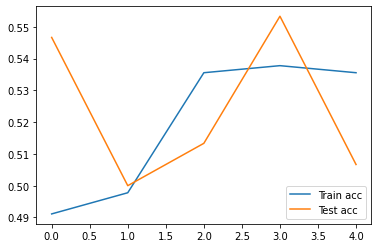

In [55]:
plt.plot(res.history['acc'], label = 'Train acc')
plt.plot(res.history['val_acc'], label = 'Test acc')
plt.legend();

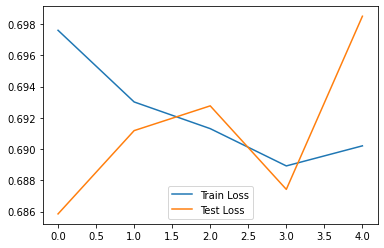

In [56]:
plt.plot(res.history['loss'], label = 'Train Loss')
plt.plot(res.history['val_loss'], label = 'Test Loss')
plt.legend();

In [63]:
# from sklearn.preprocessing import MinMaxScaler

# scalar = MinMaxScaler()
# scalar.fit(X_train)
# X = scalar.transform(X_train)

In [66]:
pred_proba = model.predict(X_test)

predict_classes=np.argmax(pred_proba,axis=1)

for pred in pred_proba:
  print(f"{pred}")

5/5 [==============================] - 0s 91ms/step
[0.43822467]
[0.48038766]
[0.44427723]
[0.46240523]
[0.45121667]
[0.44809723]
[0.4420055]
[0.44091988]
[0.4310834]
[0.43709818]
[0.49366975]
[0.4440891]
[0.47765055]
[0.43762347]
[0.44737825]
[0.4485166]
[0.44496188]
[0.4838089]
[0.44289675]
[0.49923477]
[0.4338071]
[0.44436893]
[0.44287506]
[0.45930004]
[0.45193276]
[0.43665296]
[0.45179492]
[0.45133188]
[0.44879323]
[0.43572345]
[0.51881444]
[0.43682563]
[0.46796617]
[0.46014595]
[0.46051133]
[0.4772837]
[0.44022667]
[0.44675288]
[0.43722957]
[0.44259727]
[0.4632535]
[0.5018103]
[0.4445398]
[0.45204693]
[0.43668178]
[0.44625536]
[0.49605855]
[0.4633948]
[0.5003043]
[0.44748148]
[0.4649119]
[0.48579675]
[0.47306094]
[0.45045564]
[0.4339988]
[0.43294463]
[0.46226773]
[0.46937743]
[0.44921964]
[0.50399375]
[0.4619536]
[0.44105545]
[0.47609586]
[0.43903655]
[0.44144315]
[0.4654749]
[0.4417086]
[0.43084744]
[0.46834463]
[0.46762913]
[0.44513905]
[0.45235682]
[0.46587786]
[0.43740445]
[0.

In [60]:
scores = model.evaluate(X_test, y_test, verbose=0)
for score in scores:
  print(f"{model.metrics_names[0]}: {round(score*100, 2)}%")

loss: 69.85%
loss: 50.67%
